In [5]:
import os
import numpy as np
from scipy import misc, ndimage
import matplotlib.pyplot as plt
import tifffile as tiff
import ipywidgets as widgets

In [4]:
image_path = 'C:/Users/ryans/Downloads/blood-vessel-segmentation/train/kidney_1_dense/images'

In [6]:
image_files = os.listdir(image_path)
image_files = image_files[:800]
image_files.sort()

files_tif = []
for file in image_files:
    if file.endswith('.tif'):
        files_tif.append(file)
images = np.stack([tiff.imread(image_path + '/' + file) for file in files_tif], axis=-1)

# resize images to 100x100x50
#images = images[::10, ::8, ::8]

In [12]:
images.shape

(1303, 912, 800)

In [11]:
# detect slice on z-axis in images with greatest variance
variance = np.var(images, axis=2)
z = np.argmax(variance)
print(z)


634224


In [8]:
images_large

133

Text(0.5, 1.0, 'Original image with seed point')

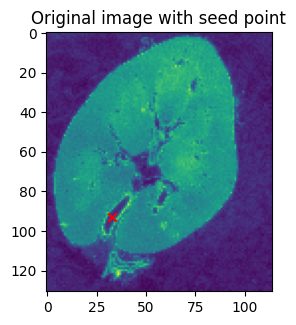

In [4]:
# Want to use method here to localize main renal artery
seed = (93, 33, 99)

# Plot the seed point on the original image (NOTE: This code is not going to work with our 3d images)
plt.subplot(121)
plt.imshow(images[:, :, seed[2]])
plt.scatter(seed[1], seed[0], c='r', marker='x')
plt.title('Original image with seed point')


In [9]:
def scroll_view_cube(images):
    def view_image(i):
        plt.imshow(images[:,:,i], cmap='gray', alpha=1.0)
    widgets.interact(view_image, i=(0, images.shape[-1]-1))

scroll_view_cube(images)

interactive(children=(IntSlider(value=399, description='i', max=799), Output()), _dom_classes=('widget-interac…

In [26]:
# create inverse of images
images_inv = 255 - images

In [37]:
images_window = images_inv > 220

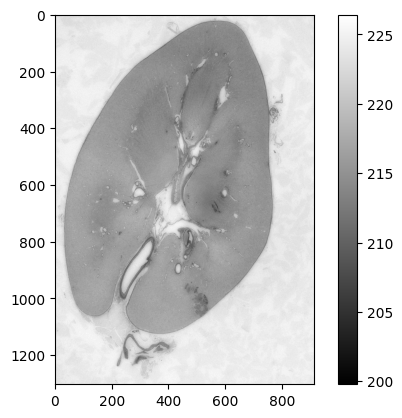

In [36]:
plt.imshow(images_inv[:, :, 780], cmap='gray')
plt.colorbar()

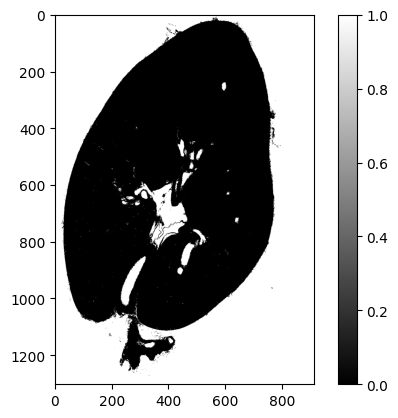

In [38]:
plt.imshow(images_window[:, :, 799], cmap='gray')
plt.colorbar()

In [8]:
scroll_view_cube(images_inv)

interactive(children=(IntSlider(value=49, description='i', max=99), Output()), _dom_classes=('widget-interact'…

In [19]:
# normalize images to [0, 100]
images = (images - images.min()) / (images.max() - images.min()) * 100

In [49]:
def filter_func(values):
    center = values[len(values) // 2]
    mean = np.mean(values)
    std = np.std(values)
    return (mean - 3 * std) <= center <= (mean + 3 * std)

filtered = ndimage.generic_filter(images, filter_func, size=3)

In [50]:
scroll_view_cube(filtered)

interactive(children=(IntSlider(value=49, description='i', max=99), Output()), _dom_classes=('widget-interact'…

KeyboardInterrupt: 

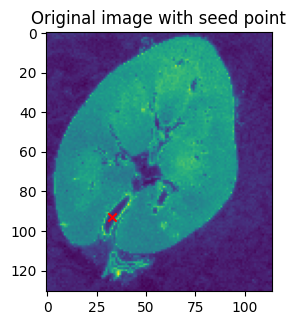

In [53]:
def is_valid(pixel, shape, visited):
    # check is a pixel is valid, i.e. within the image boundaries and not already visited
    x, y, z = pixel
    return (0 <= x < shape[0]) and (0 <= y < shape[1]) and (0 <= z < shape[2]) and not visited[x, y, z]

def get_average_color(region):
    # Compute the average color of a region, given a list of pixel values
    region = np.array(region)
    return np.mean(region)

def add_pixel_to_region(pixel, region, visited):
    # Add a pixel to a region given its color and coordinates
    color, x, y, z = pixel
    region.append(color)
    visited[x, y, z] = True

def region_growing(img, seed, threshold):
    # Perform region growing, given an image, a seed point, and a threshold
    # Define a custom filter function fo the generic filter
    '''def filter_func(values):
        # get the center pixel value
        center = values[len(values) // 2]
        # get the mean and standard deviation of the neighborhood
        mean = np.mean(values)
        std = np.std(values)
        return (mean - 3 * std) <= center <= (mean + 3 * std)'''
    
    # Apply the filter to the image
    # filtered = ndimage.generic_filter(img, filter_func, size=(3, 3, 3))
    filtered = img
    # Initialize the region and the visited array
    region = []
    visited = np.zeros(img.shape, dtype=bool)

    # Initialize the seed pixel
    seed_color = img[seed]
    add_pixel_to_region((seed_color, *seed), region, visited)

    # Initialize the list of pixels to be checked
    needs_check = [seed]

    # Loop until no more pixels can be added
    while needs_check:
        # Pop the first pixel from the list
        pixel = needs_check.pop(0)
        # Get the coordinates of the pixel
        x, y, z = pixel
        # Get the list of neighboring pixels
        neighbors = [(x-1, y, z), (x+1, y, z), (x, y-1, z), (x, y+1, z), (x, y, z-1), (x, y, z+1)]
        # Filter the neighbors to get only the valid ones
        valid_neighbors = [n for n in neighbors if is_valid(n, img.shape, visited)]
        # Loop through the valid neighbors
        for neighbor in valid_neighbors:
            # Get the color of the neighbor
            neighbor_color = img[neighbor]
            # Get the average color for the region
            average_color = get_average_color(region)
            # Check if the neighbor color is within the threshold of the average color
            if np.linalg.norm(neighbor_color - average_color) < threshold:
                # Add the neighbor to the region
                add_pixel_to_region((neighbor_color, *neighbor), region, visited)
                # Add the neighbor to the list of pixels to be checked
                needs_check.append(neighbor)
    # Label the connected components in the visited array
    labels, nlabels = ndimage.label(visited)
    # Return the component that contains the seed point
    return labels == labels[seed]

#img = misc.imread('vessels.jpg')
img = images


# Want to use method here to localize main renal artery
seed = (93, 33, 99)

# Plot the seed point on the original image
plt.subplot(121)
plt.imshow(img[:, :, seed[2]])
plt.scatter(seed[1], seed[0], c='r', marker='x')
plt.title('Original image with seed point')

# Perform region growing with a threshold
threshold = 4
region = region_growing(img, seed, threshold)

# Plot the segmented region
plt.subplot(122)
plt.imshow(region[:, :, seed[2]])
plt.title('Segmented region')
plt.show()

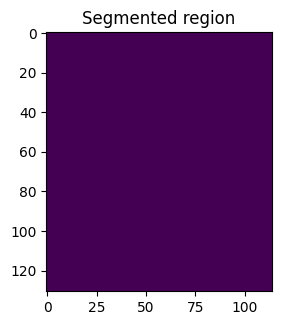

In [32]:

# Plot the segmented region
plt.subplot(122)
plt.imshow(region[:, :, 36])
plt.title('Segmented region')
plt.show()